주제 : 환경을 분석해 사람에게 도움이 되는 모델 생성

구성 : 
1. 사진 데이터 수집
2. 사진 데이터 전처리
3. 데이터셋 구성
4. 데이터로더 구성
5. 모델 구성
6. 모델 학습
7. 모델 평가
8. 모델 저장 및 불러오기
9. 모델 예측
10. 프로젝트 정리

개인 주제 : 뱀의 독성 확인

1. 이미지 로드 확인

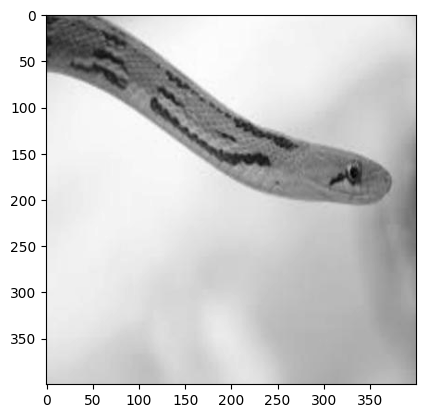

In [41]:
# 이미지 불러오기 : cv2.imread()
# 이미지 보여주기 : cv2.imshow()

import cv2
import matplotlib.pyplot as plt
import os
import cv2

# 이미지 폴더를 불러오기
# Folder path
folder_path = 'Snake Images/train/Non Venomous'

# 폴더 내 파일의 이름을 리스트로 저장
image_files_t = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

# Load and process each image : 인덱스로 불러오기
image_path_t = os.path.join(folder_path, image_files_t[0])  # 이미지 경로
img = cv2.imread(image_path_t, cv2.IMREAD_GRAYSCALE)  # 이미지 흑백으로 불러오기

# # for문 예시
# for image in image_files:
#     image_path = os.path.join(folder_path, image)
#     img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # 이미지 흑백으로 불러오기

# 이미지 출력
img_np = img.squeeze()
plt.imshow(img_np, cmap='gray')

In [42]:
# 모든 하위 폴더의 이미지 확인하기
# file_folder = 'Snake Images/train'
# for folder in os.listdir(file_folder):  # 폴더 내 파일의 이름을 리스트로 저장
#     for file in os.listdir(os.path.join(file_folder, folder)):  # 폴더 내 파일의 이름을 리스트로 저장
#         image_path = os.path.join(file_folder, folder, file)    # 이미지 경로
#         img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # 이미지 흑백으로 불러오기
#         img_np = img.squeeze()  # 이미지 출력
#         plt.imshow(img_np, cmap='gray') 
#         plt.show()

2. DataSet

In [43]:
def load_images_from_folder(folder_path):
    image_files = [f for f in os.listdir(folder_path)]
    images = []
    for image in image_files:
        image_path = os.path.join(folder_path, image)
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        # Check if the image size is empty
        if img is not None and not img.size == 0:
            # 이미지 크기 조정
            img = cv2.resize(img, (400, 400))
            images.append(img)
    return images

# 이미지 불러오기
imgs_tr_ven = load_images_from_folder('Snake Images/train/Venomous')
imgs_tr_non = load_images_from_folder('Snake Images/train/Non Venomous')
imgs_te_ven = load_images_from_folder('Snake Images/test/Venomous')
imgs_te_non = load_images_from_folder('Snake Images/test/Non Venomous')

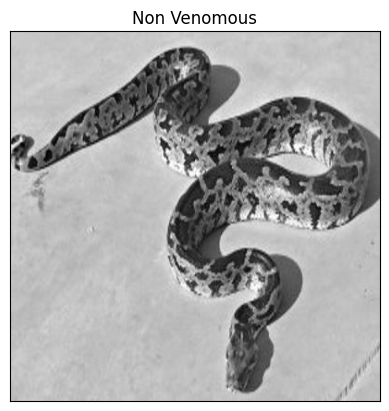

In [44]:
# 이미지 출력
plt.imshow(imgs_te_non[0], cmap='gray')
plt.title('Non Venomous')
plt.xticks([]), plt.yticks([])
plt.show()

In [45]:
# shape 확인
print(imgs_te_non[0].shape, len(imgs_te_non))

(400, 400) 127


In [46]:
# 이미지 크기 조정 : reshape()

In [47]:
# dataset class 만들기
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset

class SnakeDataset(Dataset):
    
    def __init__(self, images, label):
        super(SnakeDataset, self).__init__()
        # Tensor로 변환
        images = np.array(images)
        self.feature = torch.tensor(images, dtype=torch.float32).reshape(-1, 400*400)
        # 라벨 생성
        labels = [label for _ in range(len(images))]
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.feature)
    
    def __getitem__(self, idx):
        return self.feature[idx], self.labels[idx]

In [48]:
# 테스트
print(SnakeDataset(imgs_te_non, 0).labels.shape)
print(SnakeDataset(imgs_te_ven, 1).feature.shape)

# reshape(-1, 400*400)
# print(SnakeDataset(imgs_te_non, 0).feature.reshape(-1, 400*400).shape)

torch.Size([127])
torch.Size([141, 160000])


<hr>
2-2. Set DataSet
 <hr>

In [49]:
# dataset 만들기
train_data = SnakeDataset(imgs_tr_non, 0)
train_data += SnakeDataset(imgs_tr_ven, 1)
test_data = SnakeDataset(imgs_te_non, 0)
test_data += SnakeDataset(imgs_te_ven, 1)

train_data[0], test_data[-1], len(train_data), len(test_data)

((tensor([ 90.,  91.,  96.,  ..., 173., 173., 173.]), tensor(0)),
 (tensor([ 55.,  55.,  56.,  ..., 118., 117., 114.]), tensor(1)),
 1758,
 268)

In [50]:
train_data.datasets[0].feature
# dataset에 인덱스로 접근해야한다.

tensor([[ 90.,  91.,  96.,  ..., 173., 173., 173.],
        [133., 134., 134.,  ..., 196., 200., 200.],
        [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
        ...,
        [  3.,   3.,   3.,  ...,  31.,  26.,  19.],
        [ 50.,  53.,  52.,  ..., 113., 118., 118.],
        [ 41.,  37.,  34.,  ..., 141., 134., 139.]])

3. DataLoader

3-1. Parameter Collection

In [51]:
# Collect all of parameters
BATCH_SIZE = 8

In [80]:
from torch.utils.data import DataLoader
from torch.utils.data import random_split

# 1) Define Split
def split_dataset(dataset, split_ratio=0.8):
    seed = torch.Generator().manual_seed(11)
    train_ds, val_ds = random_split(dataset, [split_ratio, 1-split_ratio], generator=seed)
    return train_ds, val_ds

# 2) Split / DataLoader
train_ds, val_ds = split_dataset(train_data, split_ratio=0.8)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=True)

# 4) Check the length of DataLoader
len(train_ds), len(val_ds), len(train_dl), len(val_dl)

(1407, 351, 176, 44)

In [81]:
# train_dl 데이터 확인
c = 0
for x, y in train_ds:
    print(x, y)
    c += 1
    if c > 5:
        break

tensor([229., 229., 222.,  ..., 158., 153., 156.]) tensor(1)
tensor([123., 120., 117.,  ..., 197., 215., 197.]) tensor(0)
tensor([91., 70., 77.,  ..., 95., 82., 77.]) tensor(0)
tensor([ 11.,  15.,  21.,  ..., 140., 157., 176.]) tensor(0)
tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor(0)
tensor([207., 212., 211.,  ..., 133., 124., 127.]) tensor(0)


4. Model

In [54]:
import torch.nn as nn
import torch.nn.functional as F

# 모델 만들기
# - hidden layer : len(Hidden_list)-1 개
class ClassifyModel(nn.Module):
    def __init__(self, IN, Hidden_list, OUT):
        """분류 위한 심층 학습 모델

        Args:
            IN (int): 입력 피처 수
            Hidden_list (list): 은닉층 노드 수 리스트
            OUT (int): 출력 노드 수 
        """
        super(ClassifyModel, self).__init__()
        self.input_layer = nn.Linear(IN, Hidden_list[0])
        self.Hidden = nn.ModuleList([nn.Linear(Hidden_list[i], Hidden_list[i+1]) for i in range(len(Hidden_list)-1)])
        self.output_layer = nn.Linear(Hidden_list[-1], OUT)
        
    def forward(self, x):
        """모델의 forward 연산 정의

        Args:
            x (torch.Tensor): 입력 데이터

        Returns:
            torch.Tensor: 모델의 출력
        """
        x = F.relu(self.input_layer(x))
        for layer in self.Hidden:
            x = F.relu(layer(x))
        x = self.output_layer(x)
        return x

In [55]:
# 모델 테스트
IN = 100
Hidden_list = [32, 16]
OUT = 1
model_test = ClassifyModel(IN, Hidden_list, OUT)
model_test(torch.randn(8, 100))

tensor([[-0.0087],
        [ 0.0342],
        [ 0.0407],
        [-0.0196],
        [-0.0326],
        [-0.0776],
        [-0.0611],
        [-0.1180]], grad_fn=<AddmmBackward0>)

5. Training

5-1. 파라미터 및 손실함수, 최적화함수, 스케쥴러 정의

In [70]:
# 1) Parameters
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
IN, Hidden_list, OUT = 400*400, [256, 128], 1
EPOCHS = 10

# 2) 모델 정의
model = ClassifyModel(IN, Hidden_list, OUT).to(DEVICE)

# 3) opitimizer 정의 : Adam
# - 이유 : Adam이 SGD보다 빠르게 수렴
#         Adam은 learning rate를 자동으로 조절
#         Adam은 momentum과 RMSprop을 합친 것
# - 다른 optimizer : SGD, RMSprop
# - optimizer의 파라미터 : learning rate, weight_decay, momentum
# - optimizer의 파라미터 설정 : learning rate = 0.001
# - optimizer의 파라미터 설정 이유 : learning rate가 너무 크면 발산, 너무 작으면 수렴이 느림
# - optimizer의 파라미터 설정 방법 : learning rate를 0.001로 설정
# - optimizer의 파라미터 설정 방법 이유 : learning rate가 0.001이면 수렴이 빠르고 발산하지 않음
# - optimizer의 파라미터 설정 방법 : weight_decay를 0.01로 설정
# - optimizer의 파라미터 설정 방법 이유 : weight_decay가 0.01이면 overfitting을 방지
# - optimizer의 파라미터 설정 방법 : momentum을 0.9로 설정
# - optimizer의 파라미터 설정 방법 이유 : momentum이 0.9이면 수렴이 빠르고 발산하지 않음

import torch.optim as optim

LEARNING_RATE = 0.001
OPTIMIZER = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# 4) Loss function 정의
# - CrossEntropyLoss vs BCELoss
# - 이유 : BCELoss는 binary classification에 사용, CrossEntropyLoss는 multi-class classification에 사용
#          BCELoss는 sigmoid 함수를 사용, CrossEntropyLoss는 softmax 함수를 사용
LF_BCE = nn.BCEWithLogitsLoss().to(DEVICE)
LF_CE = nn.CrossEntropyLoss().to(DEVICE)

# 5) Scheduler 정의
# - StepLR vs ReduceLROnPlateau
# - 이유 : StepLR은 step_size마다 learning rate를 감소시킴
#          ReduceLROnPlateau는 validation loss가 더이상 감소하지 않을 때 learning rate를 감소시킴
#         StepLR은 학습 초기에 사용, ReduceLROnPlateau는 학습 후반에 사용
STEP_SIZE = 5
GAMMA = 0.1
MODE = 'min'
PATIENCE = 3

SCHD_ST = optim.lr_scheduler.StepLR(OPTIMIZER, step_size=STEP_SIZE, gamma=GAMMA)
SCHD_RP = optim.lr_scheduler.ReduceLROnPlateau(OPTIMIZER, mode=MODE, patience=PATIENCE)
# verbose 역할 : True이면 감소시킬 때마다 출력, False이면 감소시킬 때마다 출력하지 않음

# 6) 성능평가 지표 정의
# - Accuracy vs F1-score
# - 이유 : Accuracy는 불균형 데이터에 적합하지 않음
#          F1-score는 불균형 데이터에 적합 => F1-score 사용
from sklearn.metrics import f1_score


5-2. 학습

In [73]:
def training(DL, model, LF, OPTIMIZER, DEVICE):
    model.train()
    train_loss = []
    f1_scores = []
    for img, label in DL:
        img, label = img.to(DEVICE), label.to(DEVICE)
        OPTIMIZER.zero_grad()
        output = model(img)
        label = label.view(-1, 1)  # Reshape label tensor
        if LF == LF_BCE:
            loss = LF(output, label.float())
        else:
            loss = LF(output, len(label))
        loss.backward()
        OPTIMIZER.step()
        train_loss.append(loss.item())
        # f1_scores
        output = torch.sigmoid(output)
        output = (output > 0.5).float()
        f1_scores.append(f1_score(label.cpu(), output.cpu()))
        
    return train_loss[-1], f1_scores[-1]

training(train_dl, model, LF_BCE, OPTIMIZER, DEVICE)


0.6068919897079468

In [86]:
# scheduler 를 넣은 training 함수
def training(DL, model, LF, OPTIMIZER, DEVICE, SCHD=None):
    model.train()
    train_loss = []
    f1_scores = []
    for img, label in DL:
        img, label = img.to(DEVICE), label.to(DEVICE)
        OPTIMIZER.zero_grad()
        output = model(img)
        label = label.view(-1, 1)  # Reshape label tensor
        if LF == LF_BCE:
            loss = LF(output, label.float())
        elif LF == LF_CE:
            loss = LF(output, label.float())
        loss.backward()
        OPTIMIZER.step()
        train_loss.append(loss.item())
        # f1_scores
        output = torch.sigmoid(output)
        output = (output > 0.5).float()
        f1_scores.append(f1_score(label.cpu(), output.cpu()))
    if SCHD:
        SCHD.step()
    return train_loss[-1], f1_scores[-1]


In [87]:
# loss function 간 비교
# BCELoss, CrossEntropyLoss
print(training(train_dl, model, LF_CE, OPTIMIZER, DEVICE))
print(training(train_dl, model, LF_BCE, OPTIMIZER, DEVICE))

(-0.0, 0.923076923076923)
(0.7369444966316223, 0.6)


6. Testing

In [90]:
# DL = val_dl or test_dl
def val_testing(DL, model, LF):
    model.eval()
    val_loss = []
    f1_scores = []
    with torch.no_grad():
        for img, label in DL:
            img, label = img.to(DEVICE), label.to(DEVICE)
            output = model(img)
            label = label.view(-1, 1)  # Reshape label tensor
            if LF == LF_BCE:
                loss = LF(output, label.float())
            else:
                loss = LF(output, label.float())
            val_loss.append(loss.item())
            # f1_scores
            output = torch.sigmoid(output)
            output = (output > 0.5).float()
            f1_scores.append(f1_score(label.cpu(), output.cpu()))
    return sum(val_loss)/len(val_loss), sum(f1_scores)/len(f1_scores)

In [91]:
val_testing(val_dl, model, LF_CE)

(0.0, 0.7047636706727618)

7. Evaluation

8. Prediction

9. Save Model